In [527]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
import itertools
import os
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [528]:
import random
random.seed(10)

In [529]:
# A function to calulate "Reactions per Pathway %" for each phenotype
def Calculate_Enrichment_Coverage(enrich,sko_summ,target_col):
    enrich_coverage = enrich
    phenotypes =  sko_summ.index 
    for j in range(sko_summ.shape[0]):
        enrich_coverage[phenotypes[j]] = np.zeros((enrich.shape[0],1))
        query_genes = sko_summ.loc[phenotypes[j],target_col]
        query_genes = query_genes.split('; ')# for x in query_genes]
        #query_genes  =np.unique(np.concatenate(query_genes))
        query_genes = [x for x in query_genes if x not in ['NaN','nan']]
        for i in range(enrich.shape[0]):
            enrich_genes = enrich.Genes[i].split(';')
            shared_genes = [x for x in query_genes if x in enrich_genes]
            total_path_genes = int(enrich.Overlap[i].split('/')[1])
            enrich_coverage[phenotypes[j]][i] = len(shared_genes)/total_path_genes#len(enrich_genes)
            enrich_coverage.index = enrich_coverage.Term
    return enrich_coverage

In [530]:
from gseapy.parser import Biomart

bm = Biomart(verbose=False, host="europe.ensembl.org")
## view validated marts
marts = bm.get_marts()
## view validated dataset
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
## view validated attributes
attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl')
## view validated filters
filters = bm.get_filters(dataset='hsapiens_gene_ensembl')

In [531]:
marts

,Name,Description
0,ENSEMBL_MART_ENSEMBL,Ensembl Genes 103
1,ENSEMBL_MART_MOUSE,Mouse strains 103
2,ENSEMBL_MART_SEQUENCE,Sequence
3,ENSEMBL_MART_ONTOLOGY,Ontology
4,ENSEMBL_MART_GENOMIC,Genomic features 103
5,ENSEMBL_MART_SNP,Ensembl Variation 103
6,ENSEMBL_MART_FUNCGEN,Ensembl Regulation 103


### Calculate phenotype safety and toxicity in the SKO

In [532]:
## Calculate phenotype toxicity and essentially  for the severity study

sko = pd.read_csv('./KO_data/severity_SKO_All.csv')
sko = sko.astype('object')
sko["SKO_Unkown"] =sko["SKO_Unkown"].apply(lambda x: str(x).split('.')[0])
sko.Series = sko.Series.str.upper()
sko['RECON'] = sko.RECON.str.replace('.mat','').str.upper().str.replace('RECON','')
sko['All_genes'] = sko.SKO_Safe.astype('str')+','+sko.SKO_Toxic.astype('str')+','+sko.SKO_Unkown.astype('str')

In [533]:
sko

,Series,RECON,SKO_Safe,SKO_Toxic,SKO_Unkown,All_genes
0,S16,2,"1491,2987,51727,9791","259230,54675",6526,"1491,2987,51727,9791,259230,54675,6526"
1,S16,3D,"11136,2987,6519,9791","114134,5184,54675",nan,"11136,2987,6519,9791,114134,5184,54675,nan"
2,S1,2,NaN,"10999,1491,259230,2987,51727,54675,6526",nan,"nan,10999,1491,259230,2987,51727,54675,6526,nan"
3,S1,3D,"11136,6519","259230,2987,54675,9791",6526,"11136,6519,259230,2987,54675,9791,6526"
4,S2,2,NaN,"259230,54675",nan,"nan,259230,54675,nan"
5,S2,3D,"23657,6520","259230,51477,54675",nan,"23657,6520,259230,51477,54675,nan"
6,S5,2,1841,"259230,2987,54675",nan,"1841,259230,2987,54675,nan"
7,S5,3D,"2987,5184","23657,259230,51477,54675,6520",nan,"2987,5184,23657,259230,51477,54675,6520,nan"
8,S6,2,"10999,1719,189,7298","259230,2987,54675",nan,"10999,1719,189,7298,259230,2987,54675,nan"
9,S6,3D,NaN,"259230,2987,5184,54675",nan,"nan,259230,2987,5184,54675,nan"


In [534]:
sko_gene_list = sko.All_genes.tolist()
sko_gene_list = [x.split(',') for x in sko_gene_list]
sko_gene_list = np.unique(np.concatenate(sko_gene_list)).tolist()[:-1]
results = bm.query(dataset='hsapiens_gene_ensembl', attributes=['entrezgene_id','hgnc_symbol'],#, 'go_id'],
                      filters={'entrezgene_id': sko_gene_list})
results =  results.dropna().drop_duplicates().reset_index(drop=True)

In [535]:
sko_db = pd.DataFrame()
sko_db['Gene_Symbol'] = int(0)
sko_db['Genes'] = sko_gene_list
sko_db['Phenotype_Essentiality'] = 0
sko_db['Phenotype_Safety'] = int(0)
for i in range(sko_db.shape[0]):
    entrez = sko_gene_list[i]
    gene = results.loc[results.entrezgene_id == int(entrez),'hgnc_symbol'].values[0]
    sko_db.loc[i,'Gene_Symbol'] =  gene
    sko_db.loc[i,'Phenotype_Essentiality'] = str(sko.All_genes).count(str(entrez))
    sko_db.loc[i,'Phenotype_Safety'] = str(sko.SKO_Safe).count(str(entrez))
sko_db.index = sko_db.Gene_Symbol
sko_db.to_csv('KO_data/severity_SKO_Toxicity_Phenotype_db.csv')

In [536]:
sko_db

,Gene_Symbol,Genes,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,
SLC27A4,SLC27A4,10999,3,2
SLC7A9,SLC7A9,11136,2,2
SLC2A13,SLC2A13,114134,1,0
CTH,CTH,1491,2,1
DHFR,DHFR,1719,1,1
DTYMK,DTYMK,1841,1,1
AGXT,AGXT,189,1,1
SLC7A11,SLC7A11,23657,2,1
SGMS1,SGMS1,259230,11,0


In [537]:
## Calculate phenotype toxicity and essentially  for the timeseries study
sko = pd.read_csv('./KO_data/timeseries_SKO_All.csv')
sko = sko.astype('object')
sko.Series = sko.Series.str.upper()
sko['RECON'] = sko.RECON.str.replace('.mat','').str.upper().str.replace('RECON','')
sko['All_genes'] = sko.SKO_Safe.astype('str')+','+sko.SKO_Toxic.astype('str')

In [538]:
sko

,Series,RECON,SKO_Safe,SKO_Toxic,SKO_Unknown,All_genes
0,CALU3_12H,2,"10999,51477","259230,2987,54675,8140",NaN,"10999,51477,259230,2987,54675,8140"
1,CALU3_12H,3D,8140,"23657,259230,2987,51477,5184,54675,6520",NaN,"8140,23657,259230,2987,51477,5184,54675,6520"
2,CALU3_24H,2,NaN,"10999,259230,2987,51477,54675,8140",NaN,"nan,10999,259230,2987,51477,54675,8140"
3,CALU3_24H,3D,9791,"23657,2987,51228,51477,54675,6520",NaN,"9791,23657,2987,51228,51477,54675,6520"
4,CALU3_4H,2,NaN,"10999,259230,2987,54675",NaN,"nan,10999,259230,2987,54675"
5,CALU3_4H,3D,51228,"23657,259230,2987,51477,5184,54675,6520",NaN,"51228,23657,259230,2987,51477,5184,54675,6520"
6,CALU3_8H,2,NaN,NaN,"54675,8140,2987,10999,259230","nan,nan"
7,CALU3_8H,3D,NaN,NaN,"6520,54675,23657,51477,259230,5184,2987,51228","nan,nan"
8,H1299_12H,2,NaN,NaN,"9057,54675,1491,10999,5338,259230","nan,nan"
9,H1299_12H,3D,NaN,NaN,"54675,51477,259230,5184","nan,nan"


In [539]:
sko_gene_list = sko.All_genes.tolist()
sko_gene_list = [x.split(',') for x in sko_gene_list]
sko_gene_list = np.unique(np.concatenate(sko_gene_list)).tolist()[:-1]
results = bm.query(dataset='hsapiens_gene_ensembl', attributes=['entrezgene_id','hgnc_symbol'],#, 'go_id'],
                      filters={'entrezgene_id': sko_gene_list})
results =  results.dropna().drop_duplicates().reset_index(drop=True)

In [540]:
sko_db = pd.DataFrame()
sko_db['Gene_Symbol'] = int(0)
sko_db['Genes'] = sko_gene_list
sko_db['Phenotype_Essentiality'] = 0
sko_db['Phenotype_Safety'] = int(0)
for i in range(sko_db.shape[0]):
    entrez = sko_gene_list[i]
    gene = results.loc[results.entrezgene_id == int(entrez),'hgnc_symbol'].values[0]
    sko_db.loc[i,'Gene_Symbol'] =  gene
    sko_db.loc[i,'Phenotype_Essentiality'] = str(sko.All_genes).count(str(entrez))
    sko_db.loc[i,'Phenotype_Safety'] = str(sko.SKO_Safe).count(str(entrez))
sko_db.index = sko_db.Gene_Symbol
sko_db.to_csv('KO_data/timeseries_SKO_Toxicity_Phenotype_db.csv')

In [541]:
sko_db

,Gene_Symbol,Genes,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,
SLC27A4,SLC27A4,10999,5,1
CTH,CTH,1491,2,1
SLC7A11,SLC7A11,23657,3,0
SGMS1,SGMS1,259230,9,0
GUK1,GUK1,2987,6,0
GLTP,GLTP,51228,2,1
ISYNA1,ISYNA1,51477,7,1
PEPD,PEPD,5184,3,1
PLD2,PLD2,5338,2,0


In [542]:
### Merge the 2 lung studies
lung_1 =pd.read_csv('KO_data/severity_SKO_Toxicity_Phenotype_db.csv')
lung_2 =pd.read_csv('KO_data/timeseries_SKO_Toxicity_Phenotype_db.csv')

In [543]:
df_final = pd.merge(lung_1, lung_2, on = ['Genes','Gene_Symbol'], how = 'outer')#lung_1.merge(lung_2, left_on='Genes', right_on='Genes')
df_final.index = df_final.Gene_Symbol
df_final = df_final.fillna(0)
df_final = df_final.loc[:,['Genes','Phenotype_Safety_x','Phenotype_Essentiality_x','Phenotype_Safety_y','Phenotype_Essentiality_y','Gene_Symbol']]
df_final['Phenotype_Essentiality'] = df_final['Phenotype_Essentiality_x']+ df_final['Phenotype_Essentiality_y']
df_final['Phenotype_Safety'] = df_final['Phenotype_Safety_x']+ df_final['Phenotype_Safety_y']
#df = df.drop(columns =['Gene_Symbol'])
df_final.iloc[:,-2:] = df_final.iloc[:,-2:].astype('int')
df_final = df_final.sort_values('Phenotype_Essentiality',ascending=False)
# Replacing 0 by 1 since the count was taken by average of the 2 recon models
#df_final['Phenotype_Essentiality'] = df_final['Phenotype_Essentiality'].replace(0,1)
#df_final['Phenotype_Essentiality'] = df_final['Phenotype_Essentiality'].replace(-1,1)

df_final['Phenotype_Safety'] = df_final['Phenotype_Safety'].replace(0,1)

df_final

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,,,,,
CRLS1,54675,0.0,12.0,0.0,10.0,CRLS1,22,1
SGMS1,259230,0.0,11.0,0.0,9.0,SGMS1,20,1
GUK1,2987,3.0,10.0,0.0,6.0,GUK1,16,3
ISYNA1,51477,0.0,2.0,1.0,7.0,ISYNA1,9,1
SLC27A4,10999,2.0,3.0,1.0,5.0,SLC27A4,8,3
PEPD,5184,1.0,4.0,1.0,3.0,PEPD,7,2
SLC3A2,6520,1.0,2.0,0.0,3.0,SLC3A2,5,1
SLC7A11,23657,1.0,2.0,0.0,3.0,SLC7A11,5,1
PTDSS1,9791,2.0,3.0,1.0,1.0,PTDSS1,4,3


In [544]:
df_final.loc[:,['Genes','Gene_Symbol','Phenotype_Essentiality','Phenotype_Safety']]

,Genes,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety
Gene_Symbol,,,,
CRLS1,54675,CRLS1,22,1
SGMS1,259230,SGMS1,20,1
GUK1,2987,GUK1,16,3
ISYNA1,51477,ISYNA1,9,1
SLC27A4,10999,SLC27A4,8,3
PEPD,5184,PEPD,7,2
SLC3A2,6520,SLC3A2,5,1
SLC7A11,23657,SLC7A11,5,1
PTDSS1,9791,PTDSS1,4,3


In [545]:
df_final.loc[:,['Genes','Gene_Symbol','Phenotype_Essentiality','Phenotype_Safety']].to_csv('SKO_ALL_Studies.csv')

In [546]:
# Genes from both lung studies
df_final.index

Index(['CRLS1', 'SGMS1', 'GUK1', 'ISYNA1', 'SLC27A4', 'PEPD', 'SLC3A2',
       'SLC7A11', 'PTDSS1', 'CMPK1', 'CTH', 'SLC5A3', 'SLC7A5', 'SLC7A9',
       'SLC3A1', 'GLTP', 'PLD2', 'SLC7A6', 'AGXT', 'DTYMK', 'DHFR', 'TYMS',
       'SLC2A13'],
      dtype='object', name='Gene_Symbol')

In [547]:
df_final.shape

(23, 8)

## SKO Drug Repurposing

In [570]:
# Drug Repurposing
drugbank_df  =pd.read_csv('./DrugBank_Drug_Target_Toxicity_Only_Indication.csv',sep=',',index_col=0)
#drugbank_df = drugbank_df.drop(columns = ['drugbank_id.1'])
drugbank_df.head(5)

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids,name,type,groups,atc_codes,categories,description,hgnc_symbol,umls_cui_from_meddra,side_effect_name,Meddra_Indication
0,DB00001,target,P00734,2147,Humans,yes,inhibitor,NaN,Lepirudin,biotech,approved,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",Lepirudin is identical to natural hirudin exce...,RET,NaN,NaN,NaN
1,DB00006,target,P00734,2147,Humans,yes,inhibitor,NaN,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",Bivalirudin is a synthetic 20 residue peptide ...,RET,NaN,NaN,NaN
2,DB00025,enzyme,P00734,2147,Humans,unknown,activator,NaN,"Antihemophilic factor, human recombinant",biotech,approved|investigational,B02BD02,"Amino Acids, Peptides, and Proteins|Biological...",Human recombinant antihemophilic factor (AHF) ...,RET,NaN,NaN,NaN
3,DB00055,target,P00734,2147,Humans,unknown,NaN,NaN,Drotrecogin alfa,biotech,approved|investigational|withdrawn,B01AD10,"Amino Acids, Peptides, and Proteins|Anti-Infec...",Drotrecogin alfa is activated human protein C ...,RET,NaN,NaN,NaN
4,DB00100,target,P00734,2147,Humans,unknown,NaN,NaN,Coagulation Factor IX (Recombinant),biotech,approved|investigational,NaN,Blood Coagulation Factors|Hemostatics|Increase...,Recombinant Coagulation Factor IX is a purifie...,RET,NaN,NaN,NaN


In [571]:
# Replace drug name for large name by drug id
drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>30,'name'] =drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>30,'drugbank_id']

In [572]:
# Since the same drug different approval groups on different entries, we will unify them by concatenating
drugbank_drugs = np.unique(drugbank_df.name)
for drug in drugbank_drugs:
    drugbank_df.loc[drugbank_df.name ==drug,'groups'] = '|'.join(np.unique(drugbank_df.loc[drugbank_df.name ==drug,'groups']).tolist())

In [551]:
drugbank_df.head()

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids,name,type,groups,atc_codes,categories,description,hgnc_symbol,umls_cui_from_meddra,side_effect_name,Meddra_Indication
0,DB00001,target,P00734,2147,Humans,yes,inhibitor,NaN,Lepirudin,biotech,approved,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",Lepirudin is identical to natural hirudin exce...,RET,NaN,NaN,NaN
1,DB00006,target,P00734,2147,Humans,yes,inhibitor,NaN,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",Bivalirudin is a synthetic 20 residue peptide ...,RET,NaN,NaN,NaN
2,DB00025,enzyme,P00734,2147,Humans,unknown,activator,NaN,DB00025,biotech,approved|investigational,B02BD02,"Amino Acids, Peptides, and Proteins|Biological...",Human recombinant antihemophilic factor (AHF) ...,RET,NaN,NaN,NaN
3,DB00055,target,P00734,2147,Humans,unknown,NaN,NaN,Drotrecogin alfa,biotech,approved|investigational|withdrawn,B01AD10,"Amino Acids, Peptides, and Proteins|Anti-Infec...",Drotrecogin alfa is activated human protein C ...,RET,NaN,NaN,NaN
4,DB00100,target,P00734,2147,Humans,unknown,NaN,NaN,DB00100,biotech,approved|investigational,NaN,Blood Coagulation Factors|Hemostatics|Increase...,Recombinant Coagulation Factor IX is a purifie...,RET,NaN,NaN,NaN


In [552]:
#drugbank_df_inhibitor = drugbank_df.loc[drugbank_df.actions.astype('str').str.contains('inhibitor'),:]
#drugbank_df_inducer = drugbank_df.loc[drugbank_df.actions.astype('str').str.contains('inducer'),:]

In [553]:
# Map full gene name describtion
#gene_desc = drugbank_df[['SYMBOL','entrez_gene_id','Name']].drop_duplicates()
#gene_desc = gene_desc.dropna()
#gene_desc.entrez_gene_id= gene_desc.entrez_gene_id.apply(lambda x: int(x))

In [573]:
df_final.Genes = df_final.Genes.astype('int')

In [588]:
gtex_db = df_final #pd.concat([sko_db_safe,sko_db_some_toxic])
df = pd.DataFrame(np.zeros((10000,len(gtex_db.columns))),columns = gtex_db.columns)
df['Drugs']= 0
df['Drugs_Action'] = 0
df['Gene_Symbol'] = 0
#df = df.astype('object')
k = 0
for i in range(gtex_db.shape[0]):
    gene = gtex_db.iloc[i,0]
    if gene in drugbank_df.entrez_gene_id.tolist():
        drugs = list(set(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'name']))
        gene_drugs_df = drugbank_df.loc[drugbank_df.entrez_gene_id==gene,:]
        for l in range(len(drugs)):
            df.loc[k,'Genes'] = gene
            df.iloc[k,1:] = gtex_db.iloc[i,1:]

            df.loc[k,'Drugs'] = drugs[l]
            df.loc[k,'Drugs_Action'] = gene_drugs_df.loc[gene_drugs_df.name==drugs[l],'actions'].values[0]
            #df.loc[k,'Gene_Symbol'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'hgnc_symbol'])[l]
            df.loc[k,'Drugs_Group'] =  gene_drugs_df.loc[gene_drugs_df.name==drugs[l],'groups'].values[0] #list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'groups'])[l]
            df.loc[k,'ATC_Code'] = gene_drugs_df.loc[gene_drugs_df.name==drugs[l],'atc_codes'].values[0] #list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'atc_codes'])[l]
            df.loc[k,'Gene_Categories'] = gene_drugs_df.loc[gene_drugs_df.name==drugs[l],'category'].values[0]#list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'category'])[l]
            df.loc[k,'Drugs_Categories'] = gene_drugs_df.loc[gene_drugs_df.name==drugs[l],'categories'].values[0]#list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'categories'])[l]
            df.loc[k,'side_effect_name'] = gene_drugs_df.loc[gene_drugs_df.name==drugs[l],'side_effect_name'].values[0]#list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'side_effect_name'])[l]
            df.loc[k,'Meddra_Indication'] = gene_drugs_df.loc[gene_drugs_df.name==drugs[l],'Meddra_Indication'].values[0]#list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'Meddra_Indication'])[l]

            #df.loc[k,'Gene_Name'] = list(drugbank_df.loc[drugbank_df.entrez_gene_id==gene,'Name'])[l]
            k = k+1
    else:
        pass
df = df.loc[df.Drugs!=0,:]
#df.to_csv('Drug_Repurposing_Results/GTEx_SKO_Safe_Drugs.csv')

In [589]:
df_final['Gene_Symbol'] = df_final.index
df['Gene_Symbol'] = df.Genes.map(df_final.set_index('Genes')['Gene_Symbol'])

In [590]:
df = df.loc[df.Genes!=0,:] 

In [602]:
df.head(50)

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
0,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Valaciclovir,substrate,approved|investigational,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Acyclovir,substrate,approved,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
2,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Guanosine-5'-Monophosphate,NaN,experimental,NaN,target,NaN,NaN,NaN
3,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,Glycerin,NaN,approved|investigational,A06AX01|A06AG04,target,Alcohols|Alimentary Tract and Metabolism|Basic...,NaN,NaN
4,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,DB01840,NaN,experimental,NaN,target,Alcohols|Carbohydrates|Myo-Inositol-1-Phosphat...,NaN,NaN
5,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,2-Deoxy-Glucitol-6-Phosphate,NaN,experimental,NaN,target,NaN,NaN,NaN
6,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Cystine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
7,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Riluzole,inducer,approved|investigational,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor..."
8,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Taurochenodeoxycholic acid,NaN,experimental,NaN,transporter,"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",NaN,NaN
9,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Glutamic acid,NaN,approved|nutraceutical,A09AB01,target,Acid Preparations|Alimentary Tract and Metabol...,NaN,NaN


In [603]:
df.tail(50)

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
72,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,DB03987,NaN,experimental,NaN,target,NaN,NaN,NaN
73,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,DB02583,NaN,experimental,NaN,target,NaN,NaN,NaN
74,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,Methotrexate,inhibitor,approved,L04AX03|L01BA01,target,"Abortifacient Agents|Abortifacient Agents, Non...","['CNS toxicity', 'Gastrointestinal toxicity', ...","['Acute leukaemia', 'Acute lymphocytic leukaem..."
75,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,DB07141,NaN,experimental,NaN,target,NaN,NaN,NaN
76,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,Pyrimethamine,inhibitor,approved|investigational|vet_approved,P01BD01|P01BD51|P01BF04,target,Anti-Infective Agents|Antibiotics for Pneumocy...,NaN,"['Malaria', 'Toxoplasmosis']"
77,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,DB02919,NaN,experimental,NaN,target,NaN,NaN,NaN
78,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,Aminopterin,inhibitor,investigational|withdrawn,NaN,enzyme,Biological Factors|Enzyme Inhibitors|Folic Aci...,NaN,NaN
79,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,DB03461,NaN,experimental,NaN,target,Adenine Nucleotides|Carbohydrates|Coenzymes|En...,NaN,NaN
80,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,Pemetrexed,inhibitor,approved|investigational,L01BA04,target,"Amino Acids|Amino Acids, Acidic|Amino Acids, D...",NaN,"['Breast cancer', 'Mesothelioma', 'Non-small c..."
81,1719.0,1.0,1.0,0.0,0.0,DHFR,1.0,1.0,Lamotrigine,inhibitor,approved|investigational,N03AX09,enzyme,Agents causing hyperkalemia|Agents producing t...,NaN,"['Affective disorder', 'Bipolar I disorder', '..."


In [592]:
df.Drugs_Action.value_counts()

inhibitor        18
substrate        11
product of        2
cofactor          2
antagonist        2
activator         1
other/unknown     1
inducer           1
Name: Drugs_Action, dtype: int64

In [593]:
df.shape

(122, 16)

In [594]:
df.Drugs[0]

'Valaciclovir'

In [595]:
df  = df[df.Drugs.notna()]

In [596]:
df.shape

(122, 16)

In [597]:
df.Drugs_Group.value_counts()#.hist()

experimental                              54
approved|investigational                  19
approved                                  16
approved|nutraceutical                     8
approved|investigational|nutraceutical     6
investigational                            6
approved|investigational|vet_approved      2
approved|nutraceutical|vet_approved        2
approved|experimental                      2
approved|vet_approved                      2
approved|experimental|investigational      1
nutraceutical                              1
experimental|investigational               1
investigational|nutraceutical              1
investigational|withdrawn                  1
Name: Drugs_Group, dtype: int64

In [600]:
df[df.Drugs_Group.str.contains('nutraceutical')]

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
6,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Cystine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
9,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Glutamic acid,NaN,approved|nutraceutical,A09AB01,target,Acid Preparations|Alimentary Tract and Metabol...,NaN,NaN
17,9791.0,2.0,3.0,1.0,1.0,PTDSS1,4.0,3.0,Phosphatidyl serine,NaN,approved|investigational|nutraceutical,NaN,target,Alcohols|Carbohydrates|Dietary Supplements|Gly...,NaN,NaN
26,1491.0,1.0,2.0,1.0,2.0,CTH,4.0,2.0,Pyridoxal phosphate,cofactor,approved|investigational|nutraceutical,A11HA06,target,Alimentary Tract and Metabolism|Coenzymes|Diet...,NaN,NaN
28,1491.0,1.0,2.0,1.0,2.0,CTH,4.0,2.0,Cysteine,NaN,approved|nutraceutical,NaN,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,NaN
38,8140.0,0.0,0.0,1.0,3.0,SLC7A5,3.0,1.0,L-Glutamine,substrate,approved|investigational|nutraceutical,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN
42,11136.0,2.0,2.0,0.0,0.0,SLC7A9,2.0,2.0,Cystine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
43,11136.0,2.0,2.0,0.0,0.0,SLC7A9,2.0,2.0,L-Glutamine,substrate,approved|investigational|nutraceutical,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN
44,6519.0,2.0,2.0,0.0,0.0,SLC3A1,2.0,2.0,Cystine,NaN,approved|nutraceutical,NaN,target,"Acids|Acids, Noncarboxylic|Amino Acids|Amino A...",NaN,NaN
50,5338.0,0.0,0.0,0.0,2.0,PLD2,2.0,1.0,Choline,product of,approved|nutraceutical,NaN,target,Alcohols|Amines|Amino Alcohols|Ammonium Compou...,NaN,NaN


In [607]:
df = df.loc[~df.Drugs_Group.str.contains('withdrawn'),:]
df = df.loc[df.Drugs_Group != 'experimental',:]
df = df.loc[~df.Drugs_Group.str.contains('nutraceutical'),:]
#df = df.loc[~df.Drugs.isin(['Ethanol','NAH']),:]

In [608]:
df.Drugs_Action.value_counts()

inhibitor        17
substrate         6
antagonist        2
activator         1
other/unknown     1
inducer           1
Name: Drugs_Action, dtype: int64

In [609]:
df.shape

(49, 16)

In [610]:
len(df.Drugs.tolist())

49

In [611]:
#df = df[df.Drugs_Group.str.contains('approved')]

In [612]:
df.shape

(49, 16)

In [613]:
df.Genes.unique().shape

(8,)

In [616]:
df.head()

,Genes,Phenotype_Safety_x,Phenotype_Essentiality_x,Phenotype_Safety_y,Phenotype_Essentiality_y,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Drugs,Drugs_Action,Drugs_Group,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
0,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Valaciclovir,substrate,approved|investigational,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,2987.0,3.0,10.0,0.0,6.0,GUK1,16.0,3.0,Acyclovir,substrate,approved,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
3,51477.0,0.0,2.0,1.0,7.0,ISYNA1,9.0,1.0,Glycerin,NaN,approved|investigational,A06AX01|A06AG04,target,Alcohols|Alimentary Tract and Metabolism|Basic...,NaN,NaN
7,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Riluzole,inducer,approved|investigational,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor..."
10,23657.0,1.0,2.0,0.0,3.0,SLC7A11,5.0,1.0,Taurocholic acid,NaN,approved|experimental,NaN,transporter,"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",NaN,NaN


In [617]:

sko_db_drugs = df.loc[:,['Gene_Symbol','Drugs','Drugs_Action',#'GTEx_Safety_Class',
                           'Phenotype_Safety','Phenotype_Essentiality',#'GTEx_Safety',
                           'Drugs_Group',
                          'Gene_Categories','ATC_Code','Gene_Categories','Drugs_Categories','side_effect_name',
                          'Meddra_Indication']]
sko_db_drugs.to_csv('KO_data/SKO_db_Drugs.csv')
# With detailed toxicity for GTEx
#df.to_csv('Drug_Repurposing_Results_/SKO_db_Drugs_Detailed_Toxicity.csv')
#sko_db_drugs.to_csv('Drug_Repurposing_Results_/SKO_db_Drugs.csv')
sko_db_drugs.head(10)

,Gene_Symbol,Drugs,Drugs_Action,Phenotype_Safety,Phenotype_Essentiality,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories,Drugs_Categories,side_effect_name,Meddra_Indication
0,GUK1,Valaciclovir,substrate,3.0,16.0,approved|investigational,enzyme,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,GUK1,Acyclovir,substrate,3.0,16.0,approved,enzyme,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
3,ISYNA1,Glycerin,NaN,1.0,9.0,approved|investigational,target,A06AX01|A06AG04,target,Alcohols|Alimentary Tract and Metabolism|Basic...,NaN,NaN
7,SLC7A11,Riluzole,inducer,1.0,5.0,approved|investigational,target,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor..."
10,SLC7A11,Taurocholic acid,NaN,1.0,5.0,approved|experimental,transporter,NaN,transporter,"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",NaN,NaN
11,SLC7A11,Alanosine,NaN,1.0,5.0,investigational,transporter,NaN,transporter,"Amino Acids|Amino Acids, Peptides, and Protein...",NaN,NaN
12,SLC7A11,Thimerosal,antagonist,1.0,5.0,approved,target,D08AK06,target,Alkylmercury Compounds|Antiseptics and Disinfe...,NaN,NaN
13,SLC7A11,Tauroursodeoxycholic acid,NaN,1.0,5.0,experimental|investigational,transporter,NaN,transporter,"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",NaN,NaN
14,SLC7A11,Rosuvastatin,NaN,1.0,5.0,approved,transporter,C10BX10|C10BX05|C10BX07|C10AA07|A10BH52|G01AE1...,transporter,Agents Causing Muscle Toxicity|Alimentary Trac...,NaN,NaN
15,SLC7A11,Acetylcysteine,activator,1.0,5.0,approved|investigational,target,R05CB01|S01XA08|V03AB23,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,"['Aspartate aminotransferase increased', 'Asth..."


In [618]:
# Classify drug categrories
drug_categories = sko_db_drugs.Drugs_Categories.str.split('|').squeeze().tolist()
drug_categories = [x for x in drug_categories if str(x) !='nan']
drug_categories = np.concatenate(drug_categories)
drug_categories = pd.DataFrame(drug_categories)
drug_categories[0].value_counts().head(10)

Drugs that are Mainly Renally Excreted        20
Antineoplastic Agents                         18
Antimetabolites                               16
Immunosuppressive Agents                      15
Antineoplastic and Immunomodulating Agents    15
Toxic Actions                                 14
Enzyme Inhibitors                             14
Anti-Infective Agents                         14
Noxae                                         14
Cytochrome P-450 Substrates                   13
Name: 0, dtype: int64

In [619]:
# Classify drug indications
drug_indications = sko_db_drugs.Meddra_Indication.squeeze().tolist()


In [620]:
#sko_db_drugs.loc[sko_db_drugs.Drugs_Action.isin(['inhibitor','antagonist']),:].head()

In [621]:
#df.Drugs.to_dict()

In [622]:
sko_db_drugs.Gene_Symbol.unique().shape

(8,)

In [623]:
sko_db_drugs.shape

(49, 12)

In [624]:
# SKO Drugs with known toxic side effect
sko_db_drugs_toxic = sko_db_drugs.loc[~sko_db_drugs.side_effect_name.isna(),:]
sko_db_drugs_toxic.shape

(11, 12)

In [625]:
sko_db_drugs_toxic[['Gene_Symbol','Drugs','side_effect_name']].to_csv('./KO_data/SKO_Drugs_SIDER_toxicity.csv')

In [626]:
sko_db_drugs.shape

(49, 12)

In [627]:
sko_db_drugs.Drugs_Group.value_counts()

approved|investigational                 19
approved                                 16
investigational                           6
approved|investigational|vet_approved     2
approved|experimental                     2
approved|vet_approved                     2
approved|experimental|investigational     1
experimental|investigational              1
Name: Drugs_Group, dtype: int64

<Figure size 720x1440 with 0 Axes>

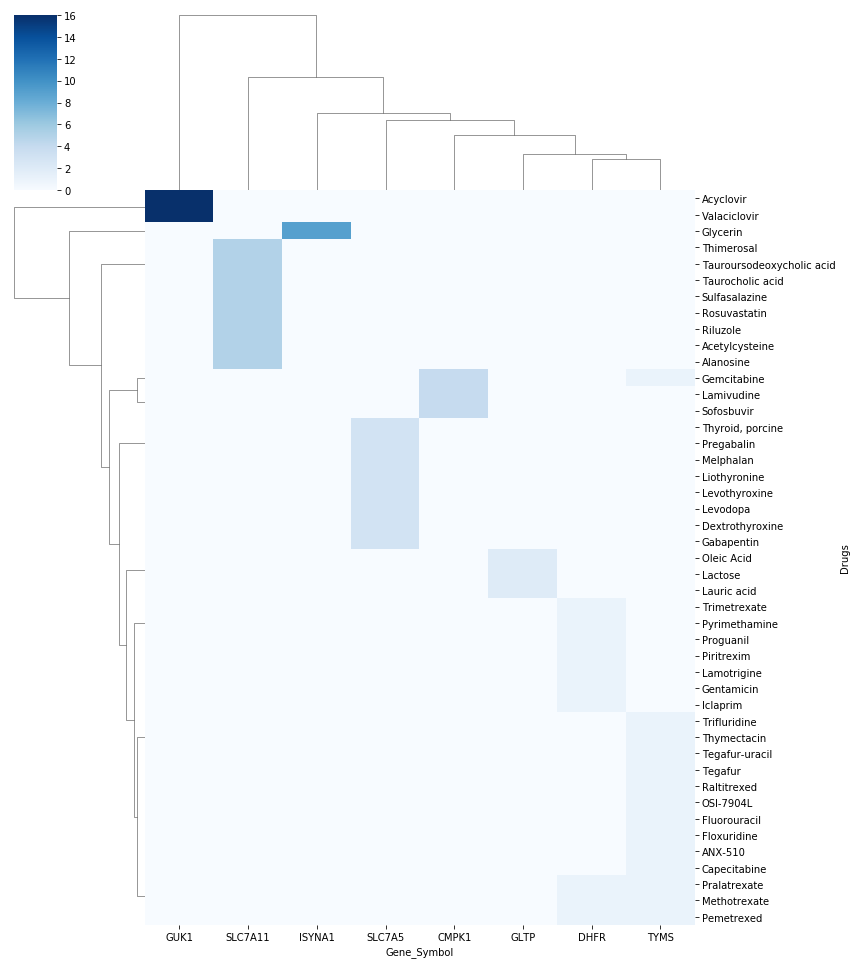

In [628]:
sko_db_drugs_hm =  sko_db_drugs.pivot_table(index='Drugs',columns = 'Gene_Symbol',values='Phenotype_Essentiality')
sko_db_drugs_hm = sko_db_drugs_hm.fillna(0)
plt.figure(figsize = (10,20))
ax = sns.clustermap(sko_db_drugs_hm.astype('int'),cmap='Blues',
                   col_cluster=True,row_cluster=True,mask=False,
                   #standard_scale=0,
                   yticklabels=True,
                   #square=True,
                   figsize=(12,(.3*(len(sko_db_drugs_hm.index)))))#,col_cluster=False,row_cluster=False)heatmap(enrich_coverage_all.iloc[:,4:], annot=True, linewidths=0.5)
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [629]:
df_uniques = df.groupby('Drugs').agg({'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      'Drugs_Group': lambda x: list(x),'Drugs_Group': lambda x: list(x),
                                      'Phenotype_Safety': lambda x: list(x),'Phenotype_Safety': lambda x: np.mean(x),
                                      'Phenotype_Essentiality': lambda x: list(x),'Phenotype_Essentiality': lambda x: np.mean(x),
                                      #'GTEx_Safety': lambda x: list(x),'GTEx_Safety': lambda x: np.mean(x),
                                      #'GTEx_Safety_Class': lambda x: list(x),'GTEx_Safety_Class': lambda x: list(x),
                                      'side_effect_name': lambda x: list(x),'side_effect_name': lambda x: list(x),
                                      'Drugs_Categories': lambda x: list(x),'Drugs_Categories': lambda x: list(x)[0]
                                     })
df_uniques['Number_Genes'] = df_uniques['Gene_Symbol'].apply(lambda x: len(x))
#df_uniques['side_effect_name'] = df_uniques['side_effect_name'].apply(lambda x: np.unique(np.squeeze(x)).tolist())

df_uniques= df_uniques.sort_values(by=['Phenotype_Essentiality'],ascending=False)
df_uniques.to_csv('KO_data/SKO_db_Drugs_Unique.csv')
df_uniques.shape

(45, 7)

In [630]:
df_uniques.iloc[:,:].loc[:,['Gene_Symbol','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']]

,Gene_Symbol,Phenotype_Essentiality,Phenotype_Safety,Number_Genes
Drugs,,,,
Valaciclovir,[GUK1],16.0,3.0,1
Acyclovir,[GUK1],16.0,3.0,1
Glycerin,[ISYNA1],9.0,1.0,1
Sulfasalazine,[SLC7A11],5.0,1.0,1
Taurocholic acid,[SLC7A11],5.0,1.0,1
Tauroursodeoxycholic acid,[SLC7A11],5.0,1.0,1
Acetylcysteine,[SLC7A11],5.0,1.0,1
Riluzole,[SLC7A11],5.0,1.0,1
Thimerosal,[SLC7A11],5.0,1.0,1


In [631]:
# Number of drugs with toxicity
df_uniques.loc[df_uniques.side_effect_name.astype('str').str.contains('toxicity'),:].shape

(8, 7)

In [632]:
df_uniques.shape

(45, 7)

In [633]:
# Classify drug categrories
drug_categories = df_uniques.Drugs_Categories.str.split('|').squeeze().tolist()
drug_categories = [x for x in drug_categories if str(x) !='nan']
drug_categories = np.concatenate(drug_categories)
drug_categories = pd.DataFrame(drug_categories)
drug_categories[0].value_counts().head(40)

Drugs that are Mainly Renally Excreted                            16
Antineoplastic Agents                                             14
Anti-Infective Agents                                             13
Antimetabolites                                                   12
Toxic Actions                                                     12
Noxae                                                             12
Enzyme Inhibitors                                                 11
Cytochrome P-450 Substrates                                       11
Carbohydrates                                                     11
Immunosuppressive Agents                                          11
Pyrimidines                                                       11
Antineoplastic and Immunomodulating Agents                        11
Amino Acids                                                       10
Amino Acids, Peptides, and Proteins                               10
Folic Acid Antagonists            

In [634]:
#df_uniques.loc[df_uniques.index.str.contains('vir'),:]

In [635]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('anti-infective'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Valaciclovir,[GUK1],[approved|investigational],3.0,16.0,[nan],"Acyclovir and prodrug|Amino Acids|Amino Acids,...",1
Acyclovir,[GUK1],[approved],3.0,16.0,[nan],Acyclovir and prodrug|Anti-Infective Agents|An...,1
Sulfasalazine,[SLC7A11],[approved],1.0,5.0,[nan],Agents causing hyperkalemia|Agents that produc...,1
Tauroursodeoxycholic acid,[SLC7A11],[experimental|investigational],1.0,5.0,[nan],"Acids|Acids, Noncarboxylic|Alkanes|Alkanesulfo...",1
Acetylcysteine,[SLC7A11],[approved|investigational],1.0,5.0,[nan],"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",1
Lamivudine,[CMPK1],[approved|investigational],3.0,4.0,[nan],Agents Causing Muscle Toxicity|Anti-HIV Agents...,1
Sofosbuvir,[CMPK1],[approved],3.0,4.0,[nan],Anti-Infective Agents|Antiinfectives for Syste...,1
Gemcitabine,"[CMPK1, TYMS]","[approved, approved]",2.0,2.5,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,2
Trimetrexate,[DHFR],[approved|investigational],1.0,1.0,[['Hepatotoxicity']],"Acids, Acyclic|Acids, Aldehydic|Anti-Infective...",1


In [636]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Nucleoside'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Valaciclovir,[GUK1],[approved|investigational],3.0,16.0,[nan],"Acyclovir and prodrug|Amino Acids|Amino Acids,...",1
Acyclovir,[GUK1],[approved],3.0,16.0,[nan],Acyclovir and prodrug|Anti-Infective Agents|An...,1
Lamivudine,[CMPK1],[approved|investigational],3.0,4.0,[nan],Agents Causing Muscle Toxicity|Anti-HIV Agents...,1
Sofosbuvir,[CMPK1],[approved],3.0,4.0,[nan],Anti-Infective Agents|Antiinfectives for Syste...,1
Gemcitabine,"[CMPK1, TYMS]","[approved, approved]",2.0,2.5,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,2
Thymectacin,[TYMS],[investigational],1.0,1.0,[nan],Carbohydrates|Deoxyribonucleosides|Deoxyuridin...,1
Trifluridine,[TYMS],[approved|investigational],1.0,1.0,[nan],Anti-Infective Agents|Antimetabolites|Antineop...,1
Fluorouracil,[TYMS],[approved],1.0,1.0,"[['Cardiotoxicity', 'Ocular toxicity']]",Antimetabolites|Antineoplastic Agents|Antineop...,1
Floxuridine,[TYMS],[approved],1.0,1.0,[['Skin toxicity']],Antimetabolites|Antineoplastic Agents|Antineop...,1


In [637]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('anticonvulsant'),:]

In [638]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('analgesics'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Sulfasalazine,[SLC7A11],[approved],1.0,5.0,[nan],Agents causing hyperkalemia|Agents that produc...,1
Gabapentin,[SLC7A5],[approved|investigational],1.0,3.0,[nan],"Acids, Acyclic|Acids, Carbocyclic|Amines|Amino...",1
Pregabalin,[SLC7A5],[approved|investigational],1.0,3.0,[['Digitalis intoxication (NOS)']],"Acids, Acyclic|Agents causing angioedema|Amino...",1


In [639]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('steroid'),'Drugs_Categories'].values

In [640]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('antiviral'),['Gene_Symbol','Number_Genes']]

,Gene_Symbol,Number_Genes
Drugs,,
Valaciclovir,[GUK1],1
Acyclovir,[GUK1],1
Lamivudine,[CMPK1],1
Sofosbuvir,[CMPK1],1
Trifluridine,[TYMS],1


In [641]:
df_uniques.shape

(45, 7)

In [642]:
drugs_immune =df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Immunosuppressive Agents'),:].index
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Immunosuppressive Agents'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Sulfasalazine,[SLC7A11],[approved],1.0,5.0,[nan],Agents causing hyperkalemia|Agents that produc...,1
Melphalan,[SLC7A5],[approved],1.0,3.0,[['Pulmonary toxicity']],Alkylating Activity|Alkylating Drugs|Amino Aci...,1
Gemcitabine,"[CMPK1, TYMS]","[approved, approved]",2.0,2.5,"[['Cardiotoxicity', 'Hepatotoxicity', 'Nephrop...",Anti-Infective Agents|Antimetabolites|Antineop...,2
Trifluridine,[TYMS],[approved|investigational],1.0,1.0,[nan],Anti-Infective Agents|Antimetabolites|Antineop...,1
Raltitrexed,[TYMS],[approved|investigational],1.0,1.0,[nan],Antimetabolites|Antineoplastic Agents|Antineop...,1
Pralatrexate,"[DHFR, TYMS]","[approved|investigational, approved|investigat...",1.0,1.0,"[nan, nan]",Antimetabolites|Antineoplastic Agents|Antineop...,2
Pemetrexed,"[DHFR, TYMS]","[approved|investigational, approved|investigat...",1.0,1.0,"[nan, nan]","Amino Acids|Amino Acids, Acidic|Amino Acids, D...",2
Methotrexate,"[DHFR, TYMS]","[approved, approved]",1.0,1.0,"[['CNS toxicity', 'Gastrointestinal toxicity',...","Abortifacient Agents|Abortifacient Agents, Non...",2
Fluorouracil,[TYMS],[approved],1.0,1.0,"[['Cardiotoxicity', 'Ocular toxicity']]",Antimetabolites|Antineoplastic Agents|Antineop...,1


In [643]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('antifungal agents'),:]

In [644]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('hyperkalemia'),:]

In [645]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('antibiotic'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Alanosine,[SLC7A11],[investigational],1.0,5.0,[nan],"Amino Acids|Amino Acids, Peptides, and Protein...",1
Pyrimethamine,[DHFR],[approved|investigational|vet_approved],1.0,1.0,[nan],Anti-Infective Agents|Antibiotics for Pneumocy...,1
Gentamicin,[DHFR],[approved|vet_approved],1.0,1.0,"[['Nephropathy toxic', 'Nephrotoxicity', 'Neur...",Agents that produce neuromuscular block (indir...,1


In [646]:
df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.lower().str.contains('cholestrol'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,


In [647]:
#drugs_antirh =df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Antirheumatic Agents'),:].index
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('Antirheumatic Agents'),:]

In [648]:
#df_uniques.loc[df_uniques.Drugs_Categories.astype('str').str.contains('lipid'),'Drugs_Categories'].values

In [649]:
df_uniques.loc[df_uniques.index.str.contains('statin'),'Drugs_Categories'].values

array(['Agents Causing Muscle Toxicity|Alimentary Tract and Metabolism|Amides|Anticholesteremic Agents|BCRP/ABCG2 Substrates|Benzene Derivatives|BSEP/ABCB11 Substrates|Cytochrome P-450 CYP2C9 Substrates|Cytochrome P-450 CYP3A Inhibitors|Cytochrome P-450 CYP3A Substrates|Cytochrome P-450 CYP3A4 Substrates|Cytochrome P-450 CYP3A4 Substrates (strength unknown)|Cytochrome P-450 CYP3A5 Inhibitors|Cytochrome P-450 CYP3A5 Substrates|Cytochrome P-450 Enzyme Inhibitors|Cytochrome P-450 Substrates|Drugs Used in Diabetes|Enzyme Inhibitors|Fluorobenzenes|Genito Urinary System and Sex Hormones|Gynecological Antiinfectives and Antiseptics|Hydrocarbons, Fluorinated|Hydrocarbons, Halogenated|Hydroxymethylglutaryl-CoA Reductase Inhibitors|Hypolipidemic Agents|Lipid Modifying Agents|Lipid Modifying Agents, Plain|Lipid Regulating Agents|Noxae|OAT3/SLC22A8 Inhibitors|OAT3/SLC22A8 Substrates|OATP1B1/SLCO1B1 Inhibitors|OATP1B1/SLCO1B1 Substrates|Pyrimidines|Sulfonamides|Sulfones|Sulfur Compounds|Toxic Actio

In [650]:
df_uniques.loc[df_uniques.index.str.contains('sartan'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,


In [651]:
df_uniques.loc[df_uniques.index.str.contains('statin'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,
Rosuvastatin,[SLC7A11],[approved],1.0,5.0,[nan],Agents Causing Muscle Toxicity|Alimentary Trac...,1


In [652]:
df_uniques.loc[df_uniques.index.str.endswith('pril'),:]

,Gene_Symbol,Drugs_Group,Phenotype_Safety,Phenotype_Essentiality,side_effect_name,Drugs_Categories,Number_Genes
Drugs,,,,,,,


In [653]:
#[x for x in drugs_immune  if x not in drugs_antirh]

In [654]:
## Find the coverage of 2 drug categories on differnt lung phenotypes
# Build an enrichmet table similar to 
db = df_uniques 
enrich = pd.DataFrame(columns = ['Term','Drugs','Genes','P-value','Overlap'],dtype='object')
terms =['Immunosuppressive','Antiviral','Antirheumatic','Hypolipidemic']#,'Anticonvulsant','Analgesic']#,'Antifungal']
enrich['Term'] = terms
enrich['P-value'] = 0

for i in range(len(terms)):
    x = db.Drugs_Categories.astype('str').str.lower().str.contains(terms[i].lower())
    #y = db.index.astype('str').str.lower().str.contains(terms[i].lower())
    #x = np.logical_or([x,y])
    genes = np.unique(np.concatenate(db.loc[x,'Gene_Symbol'])).tolist()
    enrich.loc[i,'Genes'] = ';'.join(genes)
    drugs = np.unique(db.loc[x,:].index).tolist()
    enrich.loc[i,'Drugs'] = ';'.join(drugs)
    # Total number of genes that has this term in drugbank
    x = drugbank_df.categories.astype('str').str.lower().str.contains(terms[i].lower())
    total_genes = np.unique(drugbank_df.loc[x,'entrez_gene_id']).tolist()
    enrich.loc[i,'Overlap'] = str(len(genes))+'/'+str(len(total_genes))

In [655]:
enrich.Drugs

0    Capecitabine;Floxuridine;Fluorouracil;Gemcitab...
1    Acyclovir;Lamivudine;Sofosbuvir;Trifluridine;V...
2                           Methotrexate;Sulfasalazine
3                                         Rosuvastatin
Name: Drugs, dtype: object

In [656]:
enrich

,Term,Drugs,Genes,P-value,Overlap
0,Immunosuppressive,Capecitabine;Floxuridine;Fluorouracil;Gemcitab...,CMPK1;DHFR;SLC7A11;SLC7A5;TYMS,0,5/465
1,Antiviral,Acyclovir;Lamivudine;Sofosbuvir;Trifluridine;V...,CMPK1;GUK1;TYMS,0,3/135
2,Antirheumatic,Methotrexate;Sulfasalazine,DHFR;SLC7A11;TYMS,0,3/288
3,Hypolipidemic,Rosuvastatin,SLC7A11,0,1/144


In [657]:
#sko_summ = pd.read_csv('KO_data/SKO_Mapped_Unique.csv',index_col = 0)
#sko_summ.SKO_01_Toxic_Sym = sko_summ.SKO_01_Toxic_Sym.apply(lambda x:str(x).replace(' ','; ').replace("'",'').replace('[','').replace(']',''))
#sko_summ.SKO_01_Safe_Sym = sko_summ.SKO_01_Safe_Sym.apply(lambda x:str(x).replace(' ','; ').replace("'",'').replace('[','').replace(']',''))
#sko_summ['SKO_All'] = sko_summ.SKO_01_Toxic_Sym +'; '+ sko_summ.SKO_01_Safe_Sym
#sko_summ

In [658]:
df.shape

(49, 16)

In [660]:
len(df.Drugs.unique())

45

In [664]:
df.Drugs.value_counts().head()

Methotrexate    2
Pemetrexed      2
Gemcitabine     2
Pralatrexate    2
Gabapentin      1
Name: Drugs, dtype: int64

In [659]:
# Since none of the SKO drugs shares more than 1 gene per drug
df_uniques = df.groupby('Gene_Symbol').agg({'Drugs': lambda x: list(x),'Drugs': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Gene_Symbol': lambda x: list(x),'Gene_Symbol': lambda x: list(x),
                                      #'Drugs_Group': lambda x: list(x),'Drugs_Group': lambda x: list(x),
                                      'Phenotype_Safety': lambda x: list(x),'Phenotype_Safety': lambda x: np.mean(x),
                                      'Phenotype_Essentiality': lambda x: list(x),'Phenotype_Essentiality': lambda x: np.mean(x),
                                      #'GTEx_Safety': lambda x: list(x),'GTEx_Safety': lambda x: np.mean(x),
                                      #'GTEx_Safety_Class': lambda x: list(x),'GTEx_Safety_Class': lambda x: list(x),
                                      #'side_effect_name': lambda x: list(x),'side_effect_name': lambda x: list(x),
                                      #'Drugs_Categories': lambda x: list(x),'Drugs_Categories': lambda x: list(x)[0]
                                     })
#df_uniques['Number_Genes'] = df_uniques['Gene_Symbol'].apply(lambda x: len(x))
#df_uniques['side_effect_name'] = df_uniques['side_effect_name'].apply(lambda x: np.unique(np.squeeze(x)).tolist())

df_uniques= df_uniques.sort_values(by=['Phenotype_Essentiality'],ascending=False)
df_uniques.to_csv('KO_data/SKO_db_Drugs_Unique_per_gene.csv')
df_uniques

,Drugs,Phenotype_Safety,Phenotype_Essentiality
Gene_Symbol,,,
GUK1,"[Valaciclovir, Acyclovir]",3.0,16.0
ISYNA1,[Glycerin],1.0,9.0
SLC7A11,"[Riluzole, Taurocholic acid, Alanosine, Thimer...",1.0,5.0
CMPK1,"[Lamivudine, Gemcitabine, Sofosbuvir]",3.0,4.0
SLC7A5,"[Dextrothyroxine, Pregabalin, Levothyroxine, L...",1.0,3.0
GLTP,"[Oleic Acid, Lactose, Lauric acid]",1.0,2.0
DHFR,"[Methotrexate, Pyrimethamine, Pemetrexed, Lamo...",1.0,1.0
TYMS,"[ANX-510, Fluorouracil, Capecitabine, Methotre...",1.0,1.0


### Drug Repurposing in DKO

In [423]:
# Drug Repurposing
drugbank_df  =pd.read_csv('./DrugBank_Drug_Target_Toxicity_Only_Indication.csv',sep=',',index_col=0)
#drugbank_df = drugbank_df[~drugbank_df.groups.str.contains('withdrawn')]
#drugbank_df = drugbank_df.loc[drugbank_df.groups != 'experimental',:]
#drugbank_df = drugbank_df.drop(columns = ['drugbank_id.1'])

# Replace drug name for large name by drug id
drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>40,'name'] =drugbank_df.loc[drugbank_df.name.apply(lambda x:len(x))>40,'drugbank_id']
drugbank_df.head(3)

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids,name,type,groups,atc_codes,categories,description,hgnc_symbol,umls_cui_from_meddra,side_effect_name,Meddra_Indication
0,DB00001,target,P00734,2147,Humans,yes,inhibitor,NaN,Lepirudin,biotech,approved,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",Lepirudin is identical to natural hirudin exce...,RET,NaN,NaN,NaN
1,DB00006,target,P00734,2147,Humans,yes,inhibitor,NaN,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",Bivalirudin is a synthetic 20 residue peptide ...,RET,NaN,NaN,NaN
2,DB00025,enzyme,P00734,2147,Humans,unknown,activator,NaN,"Antihemophilic factor, human recombinant",biotech,approved|investigational,B02BD02,"Amino Acids, Peptides, and Proteins|Biological...",Human recombinant antihemophilic factor (AHF) ...,RET,NaN,NaN,NaN


In [424]:
# Since the same drug different approval groups on different entries, we will unify them by concatenating
drugbank_drugs = np.unique(drugbank_df.name)
for drug in drugbank_drugs:
    drugbank_df.loc[drugbank_df.name ==drug,'groups'] = '|'.join(np.unique(drugbank_df.loc[drugbank_df.name ==drug,'groups']).tolist())

In [425]:
#drugbank_df.loc[drugbank_df.name =='Fosinopril',:]

In [426]:
#drugbank_df.loc[drugbank_df.name =='Cloxacillin',:]

In [427]:
#drugbank_df.loc[drugbank_df.name =='Gemcitabine',:]

In [428]:
gtex_db  = pd.read_csv('KO_data/DKO_Lung_Studies_Summary.csv',index_col=0)

In [429]:
gtex_db.shape

(598, 8)

In [430]:
gtex_db.head()

,Gene1,Gene2,Series,RECON,Experiment_Freq,Safety_Ratio,Gene1_Symbol,Gene2_Symbol
0,54675,11212,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '3', '2', '3', '2', '3', '2', '3', '2', ...",26,10,CRLS1,PLPBP
1,259230,11212,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '3', '2', '2', '3', '2', '3', '2', '3', ...",24,9,SGMS1,PLPBP
2,6241,50484,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",14,0,RRM2,RRM2B
3,6240,50484,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['2', '2', '2', '2', '2', '2', '2', '2', '2', ...",14,0,RRM1,RRM2B
4,6565,6564,"['CALU3_12H', 'CALU3_24H', 'CALU3_4H', 'CALU3_...","['3', '3', '3', '3', '3', '3', '3', '3', '3', ...",13,0,SLC15A2,SLC15A1


In [431]:
gtex_db.RECON[0]

"['2', '3', '2', '3', '2', '3', '2', '3', '2', '3', '2', '3', '2', '3', '2', '3', '2', '3', '2', '3', '2', '2', '3', '2', '2', '3']"

In [432]:
#gtex_db = dko_db #pd.concat([dko_db_safe,dko_db_some_toxic])
df = pd.DataFrame(np.zeros((15000,len(gtex_db.columns))),columns = gtex_db.columns)
df['Drugs_1']= 0
df['groups_1'] = 0
df['Drugs_2']= 0
df['groups_2'] = 0
drugbank_genes = drugbank_df.entrez_gene_id
df = df.astype('object')
k = 0
genes_1 =  gtex_db.iloc[:,0].unique().tolist()
for i in range(len(genes_1)):
    gene = genes_1[i]
    if int(gene) in drugbank_df.entrez_gene_id.tolist():
        genes_2 = gtex_db.loc[gtex_db.Gene1==gene,'Gene2']
        genes_2 = [int(x) for x in genes_2 if int(x) in drugbank_genes]

        drugs_1 = list(set(drugbank_df.loc[drugbank_genes==int(gene),'name']))
        drugs_2 = drugbank_df.loc[drugbank_genes.isin(genes_2),'name'].tolist()
        groups_2 = drugbank_df.loc[drugbank_genes.isin(genes_2),'groups'].tolist()

        genes_2_ext = drugbank_df.loc[drugbank_genes.isin(genes_2),'entrez_gene_id'].tolist()

        for l in range(len(drugs_1)):
            df.loc[k:k + len(genes_2_ext)-1,'Gene1'] = int(gene)
            #df.iloc[k+ len(genes_2_ext),1:] = gtex_db.iloc[i,1:]

            df.loc[k:k+ len(genes_2_ext)-1,'Drugs_1'] = drugs_1[l]
            df.loc[k:k+ len(genes_2_ext)-1,'groups_1'] = list(drugbank_df.loc[drugbank_df.name==drugs_1[l],'groups'])[0]

            df.loc[k:k + len(genes_2_ext)-1,'Gene2'] = genes_2_ext
            df.loc[k:k + len(genes_2_ext)-1,'Drugs_2'] = drugs_2
            df.loc[k:k + len(genes_2_ext)-1,'groups_2'] = groups_2

            k = k +len(genes_2_ext) 
    else:
        pass

#df = df.loc[df.Drugs_1!=0,:]
#df.to_csv('Drug_Repurposing_Results/GTEx_SKO_Safe_Drugs.csv')

In [433]:
df.Gene1 = df.Gene1.astype('int') 
df.Gene2 = df.Gene2.astype('int')
gtex_db.Gene1 = gtex_db.Gene1.astype('int') 
gtex_db.Gene2 = gtex_db.Gene2.astype('int')

In [434]:
# Mapping the gene symbol and essentiality
for i in range(gtex_db.shape[0]):
    gene1 = int(gtex_db.loc[i,'Gene1'])
    gene2 = int(gtex_db.loc[i,'Gene2'])
    cols = ['Series','RECON','Experiment_Freq','Safety_Ratio','Gene1_Symbol','Gene2_Symbol']
    df.loc[np.logical_and(df.Gene1==gene1,df.Gene2==gene2),cols] = gtex_db.loc[np.logical_and(gtex_db.Gene1 ==gene1,gtex_db.Gene2==gene2),cols].values

In [435]:
df.head(5)

,Gene1,Gene2,Series,RECON,Experiment_Freq,Safety_Ratio,Gene1_Symbol,Gene2_Symbol,Drugs_1,groups_1,Drugs_2,groups_2
0,6241,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '3', '2', '3', '2', '3', '2', ...",10,0,RRM2,GUK1,Motexafin gadolinium,investigational,Valaciclovir,approved|investigational
1,6241,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '3', '2', '3', '2', '3', '2', ...",10,0,RRM2,GUK1,Motexafin gadolinium,investigational,Acyclovir,approved
2,6241,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '3', '2', '3', '2', '3', '2', ...",10,0,RRM2,GUK1,Motexafin gadolinium,investigational,Guanosine-5'-Monophosphate,experimental
3,6241,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '3', '2', '3', '2', '3', '2', ...",10,0,RRM2,GUK1,GTI 2040,investigational,Valaciclovir,approved|investigational
4,6241,2987,"['H1299_12H', 'H1299_24H', 'H1299_36H', 'H1299...","['2', '3', '2', '3', '2', '3', '2', '3', '2', ...",10,0,RRM2,GUK1,GTI 2040,investigational,Acyclovir,approved


In [436]:
df.shape

(15000, 12)

In [437]:
df = df.loc[df.Drugs_1!=0,:]

In [438]:
df.tail(5)

,Gene1,Gene2,Series,RECON,Experiment_Freq,Safety_Ratio,Gene1_Symbol,Gene2_Symbol,Drugs_1,groups_1,Drugs_2,groups_2
11201,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Copper,approved|investigational,DB02783,experimental
11202,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Maleic Acid,experimental,Pyridoxal phosphate,approved|investigational|nutraceutical
11203,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Maleic Acid,experimental,Aspartic acid,approved|nutraceutical
11204,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Maleic Acid,experimental,Glutamic acid,approved|nutraceutical
11205,2805,2806,['S2'],['2'],1,0,GOT1,GOT2,Maleic Acid,experimental,DB02783,experimental


In [439]:
dko_summ = df.loc[:,['Gene1_Symbol','Gene2_Symbol','Drugs_1','Drugs_2','groups_1','groups_2','Experiment_Freq','Safety_Ratio']]
dko_summ.columns = ['Gene1_Symbol', 'Gene2_Symbol', 'Drugs_1', 'Drugs_2', 'Drugs_Group_1', 'Drugs_Group_2','Phenotype_Essentiality','Phenotype_Safety']

In [440]:
dko_summ.head()

,Gene1_Symbol,Gene2_Symbol,Drugs_1,Drugs_2,Drugs_Group_1,Drugs_Group_2,Phenotype_Essentiality,Phenotype_Safety
0,RRM2,GUK1,Motexafin gadolinium,Valaciclovir,investigational,approved|investigational,10,0
1,RRM2,GUK1,Motexafin gadolinium,Acyclovir,investigational,approved,10,0
2,RRM2,GUK1,Motexafin gadolinium,Guanosine-5'-Monophosphate,investigational,experimental,10,0
3,RRM2,GUK1,GTI 2040,Valaciclovir,investigational,approved|investigational,10,0
4,RRM2,GUK1,GTI 2040,Acyclovir,investigational,approved,10,0


In [442]:
dko_summ.shape

(11206, 8)

In [498]:
#df.groups_1.value_counts()

In [500]:
#df.groups_2.value_counts()

In [445]:
dko_summ.shape

(11206, 8)

In [446]:
dko_summ = dko_summ.drop_duplicates()

In [447]:
dko_summ.shape

(10709, 8)

In [448]:
# One drug for target pair
#dko_summ.loc[dko_summ.Drugs_1==dko_summ.Drugs_2,:].to_csv('Drug_Repurposing_Results_/DKO_Drugs_OneDrug.csv')
#dko_summ.loc[dko_summ.Drugs_1==dko_summ.Drugs_2,:].head(50)

In [449]:
#dko_summ.loc[dko_summ.Drugs_1==dko_summ.Drugs_2,:].tail(20)

In [501]:
# Number of drugable gene pairs
dko_summ.loc[:,['Gene1_Symbol','Gene2_Symbol']].drop_duplicates().shape

(56, 2)

In [450]:
# Filter by drug groups

dko_summ = dko_summ[~dko_summ.Drugs_Group_1.str.contains('withdrawn')]
dko_summ = dko_summ.loc[dko_summ.Drugs_Group_1 != 'experimental',:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_1.str.contains('nutraceutical'),:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_1.isin(['Ethanol','NADH','Succinic acid','Glycerin']),:]

#dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_1.str.contains( 'nutraceutical'),:]

#dko_summ = dko_summ.loc[dko_summ.Drugs_Group_1 != 'withdrawn',:]
dko_summ = dko_summ[~dko_summ.Drugs_Group_2.str.contains('withdrawn')]
dko_summ = dko_summ.loc[dko_summ.Drugs_Group_2 != 'experimental',:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_1.str.contains('nutraceutical'),:]
dko_summ = dko_summ.loc[~dko_summ.Drugs_2.isin(['Ethanol','NADH','Succinic acid','Glycerin']),:]

#dko_summ = dko_summ.loc[~dko_summ.Drugs_Group_2.str.contains('nutraceutical'),:]

#dko_summ = dko_summ.loc[dko_summ.Drugs_Group_2 != 'withdrawn',:]


In [451]:
#dko_summ.loc[dko_summ.Drugs_2 =='Gemcitabine',:]

In [452]:
#dko_summ.loc[dko_summ.Drugs_2 =='Fosinopril',:]

In [453]:
dko_summ.shape

(4529, 8)

In [454]:
#dko_summ = dko_summ.loc[dko_summ.Phenotype_Essentiality>2,:]

In [455]:
dko_summ.shape

(4529, 8)

In [456]:
dko_summ.head(20)

,Gene1_Symbol,Gene2_Symbol,Drugs_1,Drugs_2,Drugs_Group_1,Drugs_Group_2,Phenotype_Essentiality,Phenotype_Safety
0,RRM2,GUK1,Motexafin gadolinium,Valaciclovir,investigational,approved|investigational,10,0
1,RRM2,GUK1,Motexafin gadolinium,Acyclovir,investigational,approved,10,0
3,RRM2,GUK1,GTI 2040,Valaciclovir,investigational,approved|investigational,10,0
4,RRM2,GUK1,GTI 2040,Acyclovir,investigational,approved,10,0
6,RRM2,GUK1,Gallium nitrate,Valaciclovir,approved|investigational,approved|investigational,10,0
7,RRM2,GUK1,Gallium nitrate,Acyclovir,approved|investigational,approved,10,0
9,RRM2,GUK1,Imexon,Valaciclovir,investigational,approved|investigational,10,0
10,RRM2,GUK1,Imexon,Acyclovir,investigational,approved,10,0
12,RRM2,GUK1,Cladribine,Valaciclovir,approved|investigational,approved|investigational,10,0
13,RRM2,GUK1,Cladribine,Acyclovir,approved|investigational,approved,10,0


In [457]:
# Safe drug pairs
#dko_summ.loc[dko_summ.DKO_Toxicity=='Safe',:].head(20)

#*** DKO drug pairs with agonist in any
idx = np.logical_or(dko_summ.MOA_1.isin(['inducer','activator','agonist','stimulator']),dko_summ.MOA_2.isin(['inducer','activator','agonist','stimulator']))
dko_summ_inducer = dko_summ.loc[idx,:]
#dko_summ_inducer = dko_summ_inducer.loc[dko_summ_inducer.MOA_2.isin(['inducer','activator','agonist']),:]

In [458]:
#dko_summ_inducer.head()

In [459]:
dko_summ['Gene_Pair'] = dko_summ.Gene1_Symbol.astype('str')+';'+dko_summ.Gene2_Symbol.astype('str')
dko_summ['Drug_Pair'] = dko_summ.Drugs_1.astype('str')+';'+dko_summ.Drugs_2.astype('str')


In [460]:
# Change dublicated drug pairs with a unifed name pairs
for i in range(dko_summ.shape[0]):
    drug1 = dko_summ.iloc[i,2]
    drug2 = dko_summ.iloc[i,3]
    for k in range(i+1,dko_summ.shape[0],1):
        if drug1 == dko_summ.iloc[k,3] and drug2 == dko_summ.iloc[k,2]:
            dko_summ.iloc[k,9] = dko_summ.iloc[i,9]
        else:
            pass

In [461]:
df_uniques = dko_summ.groupby('Drug_Pair').agg({'Gene_Pair': lambda x: set(x),'Gene_Pair': lambda x: set(x),
                                     'Phenotype_Essentiality': lambda x: list(x),'Phenotype_Essentiality': lambda x: np.mean(x),
                                          'Phenotype_Safety': lambda x: list(x),'Phenotype_Safety': lambda x: np.mean(x)
                                         })
df_uniques['Number_Genes'] = df_uniques['Gene_Pair'].apply(lambda x: len(x))
df_uniques= df_uniques.sort_values(by=['Number_Genes'],ascending=False)
df_uniques['Drugs1'] =  pd.Series({x: x.split(';')[0] for x in df_uniques.index})
df_uniques['Drugs2'] =  pd.Series({x: x.split(';')[1] for x in df_uniques.index})
df_uniques.to_csv('KO_data/DKO_Drug_Repurposing_Unique.csv')
df_uniques.shape

(3411, 6)

In [462]:
df_uniques.sort_values(by=['Number_Genes'],ascending=False)

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Azathioprine;Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.80,0.4,5,Azathioprine,Pemetrexed
Mercaptopurine;Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.80,0.4,5,Mercaptopurine,Pemetrexed
Trifluridine;Pemetrexed,"{TYMP;DHFR, SLC29A2;SLC29A1, TYMS;SLC29A2, TYM...",1.20,0.8,5,Trifluridine,Pemetrexed
Trifluridine;Pralatrexate,"{TYMS;SLC29A2, TYMP;DHFR, TYMS;TYMP, DHFR;SLC2...",1.00,0.5,4,Trifluridine,Pralatrexate
Gemcitabine;Levocarnitine,"{CMPK1;CPT2, CMPK1;SLC22A5, CMPK1;SLC25A20, SL...",1.75,1.0,4,Gemcitabine,Levocarnitine
...,...,...,...,...,...,...
Tezacitabine;Pyrimethamine,{TYMP;DHFR},1.00,1.0,1,Tezacitabine,Pyrimethamine
Tezacitabine;Trimetrexate,{TYMP;DHFR},1.00,1.0,1,Tezacitabine,Trimetrexate
Tezacitabine;Valaciclovir,{RRM1;GUK1},10.00,0.0,1,Tezacitabine,Valaciclovir


In [463]:
df_uniques.head(20)

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Azathioprine;Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.800000,0.400000,5,Azathioprine,Pemetrexed
Trifluridine;Pemetrexed,"{TYMP;DHFR, SLC29A2;SLC29A1, TYMS;SLC29A2, TYM...",1.200000,0.800000,5,Trifluridine,Pemetrexed
Mercaptopurine;Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.800000,0.400000,5,Mercaptopurine,Pemetrexed
Trifluridine;Pralatrexate,"{TYMS;SLC29A2, TYMP;DHFR, TYMS;TYMP, DHFR;SLC2...",1.000000,0.500000,4,Trifluridine,Pralatrexate
Gemcitabine;Levocarnitine,"{CMPK1;CPT2, CMPK1;SLC22A5, CMPK1;SLC25A20, SL...",1.750000,1.000000,4,Gemcitabine,Levocarnitine
Didanosine;Gemcitabine,"{TYMS;SLC29A2, CMPK1;PNP, CMPK1;SLC29A2, SLC29...",1.600000,1.200000,4,Didanosine,Gemcitabine
Trifluridine;Gemcitabine,"{CMPK1;SLC29A2, TYMS;TYMP, TYMS;SLC29A2, SLC29...",1.500000,1.000000,4,Trifluridine,Gemcitabine
Methotrexate;Pyridoxal phosphate,"{GGH;CTH, DHFR;PLPBP, TYMS;PLPBP, SLCO1A2;CTH}",1.000000,0.500000,4,Methotrexate,Pyridoxal phosphate
Trifluridine;Methotrexate,"{TYMS;SLC29A2, TYMP;DHFR, TYMS;TYMP, DHFR;SLC2...",1.000000,0.500000,4,Trifluridine,Methotrexate


In [464]:
# One drug for target pair
dko_one_drug = df_uniques.loc[df_uniques.Drugs1==df_uniques.Drugs2,:]
#dko_one_drug.to_csv('Drug_Repurposing_Results_/DKO_Drugs_OneDrug.csv')
dko_one_drug.shape

(47, 6)

In [465]:
dko_one_drug

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Gemcitabine;Gemcitabine,"{CMPK1;SLC29A2, TYMS;SLC29A2, SLC29A2;SLC29A1}",1.666667,1.0,3,Gemcitabine,Gemcitabine
Trifluridine;Trifluridine,"{TYMS;TYMP, TYMS;SLC29A2, SLC29A2;SLC29A1}",1.333333,1.0,3,Trifluridine,Trifluridine
Tegafur-uracil;Tegafur-uracil,"{TYMS;SLC29A2, SLC29A2;SLC29A1}",1.500000,1.0,2,Tegafur-uracil,Tegafur-uracil
Mercaptopurine;Mercaptopurine,"{PPAT;HPRT1, SLC29A2;SLC29A1}",3.500000,1.0,2,Mercaptopurine,Mercaptopurine
Valaciclovir;Valaciclovir,{SLC15A2;SLC15A1},13.000000,0.0,1,Valaciclovir,Valaciclovir
Moexipril;Moexipril,{SLC15A2;SLC15A1},13.000000,0.0,1,Moexipril,Moexipril
Nateglinide;Nateglinide,{SLC15A2;SLC15A1},13.000000,0.0,1,Nateglinide,Nateglinide
Oxacillin;Oxacillin,{SLC15A2;SLC15A1},13.000000,0.0,1,Oxacillin,Oxacillin
Perindopril;Perindopril,{SLC15A2;SLC15A1},13.000000,0.0,1,Perindopril,Perindopril


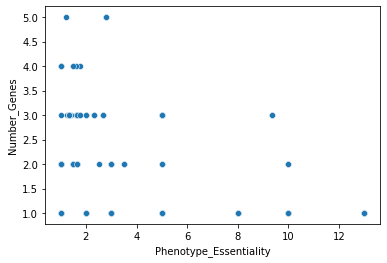

In [466]:
sns.scatterplot(df_uniques['Phenotype_Essentiality'],df_uniques['Number_Genes'])

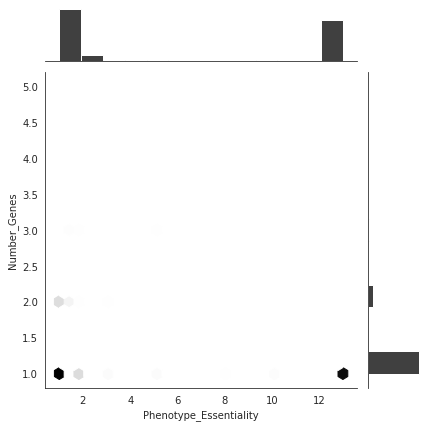

In [467]:
x, y = df_uniques['Phenotype_Essentiality'],df_uniques['Number_Genes']
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex", color="k");
    

In [468]:
#df_uniques['Duplicated_drugs'] = 0

In [469]:
#df_uniques.shape

In [470]:
#df_uniques.Phenotype_Essentiality.hist()

In [471]:
#df_uniques.Number_Genes.hist()

In [472]:
df_uniques= df_uniques.sort_values(by=['Phenotype_Essentiality'],ascending=False)

df_uniques.head(20)

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Amoxicillin;Chlorpropamide,{SLC15A2;SLC15A1},13.0,0.0,1,Amoxicillin,Chlorpropamide
Ceftazidime;Captopril,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Captopril
Ceftazidime;Cefotaxime,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Cefotaxime
Ceftazidime;Cefradine,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Cefradine
Ceftazidime;Ceftazidime,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Ceftazidime
Ceftazidime;Ceftriaxone,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Ceftriaxone
Ceftazidime;Cyclacillin,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Cyclacillin
Ceftazidime;Dexibuprofen,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Dexibuprofen
Ceftazidime;Enalapril,{SLC15A2;SLC15A1},13.0,0.0,1,Ceftazidime,Enalapril


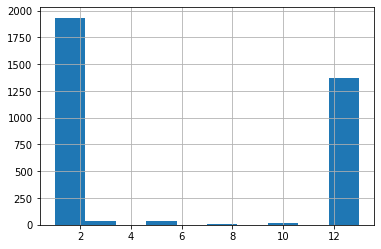

In [473]:
df_uniques.Phenotype_Essentiality.hist()

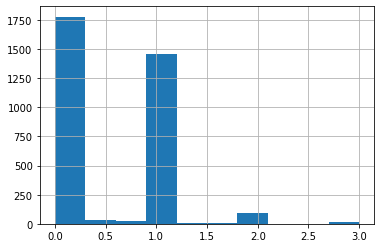

In [474]:
df_uniques.Phenotype_Safety.hist()

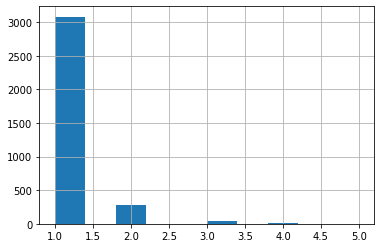

In [475]:
df_uniques.Number_Genes.hist()

In [476]:
# Filtering by essentiality and safety
#df_uniques = df_uniques.loc[df_uniques.Phenotype_Essentiality>1,:]
#df_uniques = df_uniques.loc[df_uniques.Phenotype_Safety>=1,:]

In [477]:
# Filtering by essentiality and safety and number of gene-pairs

import functools
df_reduced = df_uniques.loc[functools.reduce(np.logical_and,(df_uniques.Phenotype_Essentiality>1,df_uniques.Number_Genes>1,df_uniques.Phenotype_Safety>1)),:]

In [478]:
idx = np.logical_or(df_uniques.Number_Genes>1,df_uniques.Phenotype_Safety>1)

df_reduced2 = df_uniques.loc[idx,:]
df_reduced2 = df_reduced2.loc[df_reduced2.Phenotype_Essentiality>2,:]

In [479]:
idx = np.logical_and(df_uniques.Phenotype_Essentiality>=2,df_uniques.Phenotype_Safety>1)
df_reduced = df_uniques.loc[idx,:]

In [480]:
df_reduced.shape

(105, 6)

In [481]:
df_reduced2.shape

(52, 6)

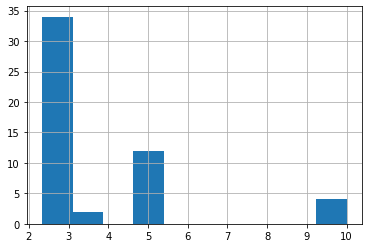

In [482]:
df_reduced2.Phenotype_Essentiality.hist()

In [483]:
df_reduced

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Taurocholic acid;Phosphatidyl serine,{SLC16A1;PTDSS1},3.0,3.0,1,Taurocholic acid,Phosphatidyl serine
Nateglinide;Phosphatidyl serine,{SLC16A1;PTDSS1},3.0,3.0,1,Nateglinide,Phosphatidyl serine
Lamivudine;Phosphatidyl serine,{CMPK1;PTDSS1},3.0,2.0,1,Lamivudine,Phosphatidyl serine
Quercetin;Phosphatidyl serine,{SLC16A1;PTDSS1},3.0,3.0,1,Quercetin,Phosphatidyl serine
Probenecid;Phosphatidyl serine,{SLC16A1;PTDSS1},3.0,3.0,1,Probenecid,Phosphatidyl serine
...,...,...,...,...,...,...
Azathioprine;Cannabidiol,{SLC29A2;SLC29A1},2.0,2.0,1,Azathioprine,Cannabidiol
Azathioprine;Fostamatinib,{SLC29A2;SLC29A1},2.0,2.0,1,Azathioprine,Fostamatinib
Azathioprine;Phosphatidyl serine,{SLC29A2;PTDSS1},2.0,2.0,1,Azathioprine,Phosphatidyl serine


In [484]:
df_reduced.sort_values(by=['Number_Genes'],ascending=False).head()

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Gemcitabine;Phosphatidyl serine,"{SLC29A2;PTDSS1, CMPK1;PTDSS1}",2.5,2.0,2,Gemcitabine,Phosphatidyl serine
Taurocholic acid;Phosphatidyl serine,{SLC16A1;PTDSS1},3.0,3.0,1,Taurocholic acid,Phosphatidyl serine
Gemcitabine;Fostamatinib,{SLC29A2;SLC29A1},2.0,2.0,1,Gemcitabine,Fostamatinib
Didanosine;Ribavirin,{SLC29A2;SLC29A1},2.0,2.0,1,Didanosine,Ribavirin
Didanosine;Uridine,{SLC29A2;SLC29A1},2.0,2.0,1,Didanosine,Uridine


In [485]:
df_reduced2.sort_values(by=['Number_Genes'],ascending=False).head()

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Azathioprine;Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.800000,0.400000,5,Azathioprine,Pemetrexed
Mercaptopurine;Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.800000,0.400000,5,Mercaptopurine,Pemetrexed
Methotrexate;Mercaptopurine,"{TYMS;SLC29A2, DHFR;SLC29A2, ATIC;HPRT1}",2.333333,0.000000,3,Methotrexate,Mercaptopurine
Cefepime;Methotrexate,"{SLC22A5;DHFR, SLC22A5;TYMS, SLC15A2;SLC15A1}",5.000000,0.666667,3,Cefepime,Methotrexate
Azathioprine;Fluorouracil,"{TYMS;SLC29A2, PPAT;HPRT1, SLC29A2;SLC29A1}",2.666667,0.666667,3,Azathioprine,Fluorouracil


In [486]:
df_reduced2.tail()

,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes,Drugs1,Drugs2
Drug_Pair,,,,,,
Azathioprine;Fluorouracil,"{TYMS;SLC29A2, PPAT;HPRT1, SLC29A2;SLC29A1}",2.666667,0.666667,3,Azathioprine,Fluorouracil
Mercaptopurine;Fluorouracil,"{TYMS;SLC29A2, PPAT;HPRT1, SLC29A2;SLC29A1}",2.666667,0.666667,3,Mercaptopurine,Fluorouracil
Gemcitabine;Phosphatidyl serine,"{SLC29A2;PTDSS1, CMPK1;PTDSS1}",2.500000,2.000000,2,Gemcitabine,Phosphatidyl serine
Methotrexate;Azathioprine,"{TYMS;SLC29A2, DHFR;SLC29A2, ATIC;HPRT1}",2.333333,0.000000,3,Methotrexate,Azathioprine
Methotrexate;Mercaptopurine,"{TYMS;SLC29A2, DHFR;SLC29A2, ATIC;HPRT1}",2.333333,0.000000,3,Methotrexate,Mercaptopurine


In [487]:
import math


In [488]:
dko_one_drug  = dko_one_drug.loc[:,['Drugs1','Gene_Pair','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']]
dko_one_drug.columns = ['Drug','Gene_Pair','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']
dko_one_drug['Phenotype_Essentiality'] = dko_one_drug['Phenotype_Essentiality'].apply(lambda x: math.floor(x * 100)/100.0)
dko_one_drug['Phenotype_Safety'] = dko_one_drug['Phenotype_Safety'].apply(lambda x: math.floor(x * 100)/100.0)

dko_one_drug['Number_Genes']=dko_one_drug['Number_Genes'].astype('int')

In [489]:
dko_one_drug = dko_one_drug.sort_values(by=['Number_Genes','Phenotype_Essentiality'],ascending=False)
dko_one_drug.reset_index(inplace=True,drop=True)
dko_one_drug.to_csv('KO_data/DKO_Drugs_OneDrug.csv')


In [490]:
df_uniques.to_csv('KO_data/DKO_Drug_Repurposing_Unique.csv')


In [491]:
all_dko_drugs = df_reduced.index.tolist()
all_dko_drugs = np.unique(np.concatenate([str(x).split(';') for x in all_dko_drugs]))
dko_cor_1 = pd.DataFrame(columns =all_dko_drugs, index = all_dko_drugs )
dko_cor_2 = pd.DataFrame(columns =all_dko_drugs, index = all_dko_drugs )
dko_cor_3 = pd.DataFrame(columns =all_dko_drugs, index = all_dko_drugs )
dko_cor_1 = dko_cor_1.fillna(0)
for x in range(df_reduced.shape[0]):
    drug1, drug2 = df_reduced.index[x].split(';')
    dko_cor_1.loc[drug1,drug2] = df_reduced.iloc[x,1]
        

In [492]:
len(all_dko_drugs)

37

<Figure size 1440x1440 with 0 Axes>

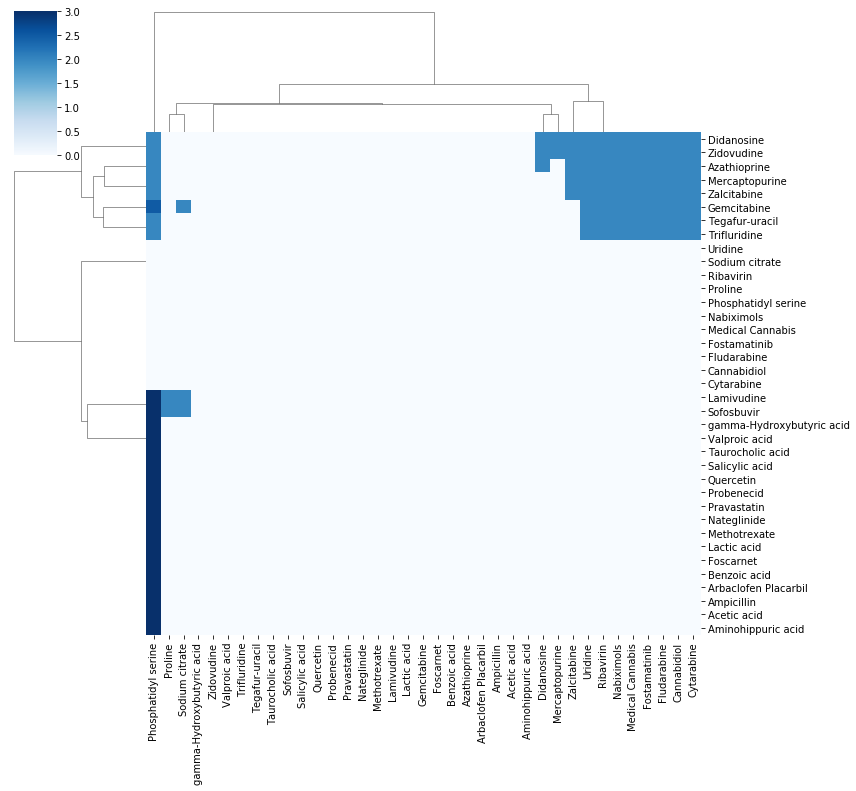

In [493]:
plt.figure(figsize = (20,20))
ax = sns.clustermap(dko_cor_1.astype('float'),cmap='Blues',
                   col_cluster=True,
                    row_cluster=True,
                   #mask=False,
                   #standard_scale=0,
                   yticklabels=True,
                   #square=True,
                   figsize=(12,(.3*(len(dko_cor_1.index)))))#,col_cluster=False,row_cluster=False)heatmap(enrich_coverage_all.iloc[:,4:], annot=True, linewidths=0.5)

In [494]:
df_reduced  = df_reduced2.loc[:,['Drugs1','Drugs2','Gene_Pair','Phenotype_Essentiality','Phenotype_Safety','Number_Genes']]
df_reduced.reset_index(inplace=True,drop=True)
df_reduced['Phenotype_Essentiality'] = df_reduced['Phenotype_Essentiality'].apply(lambda x: math.floor(x * 100)/100.0)
df_reduced['Phenotype_Safety'] = df_reduced['Phenotype_Safety'].apply(lambda x: math.floor(x * 100)/100.0)
df_reduced = df_reduced.sort_values(by=['Number_Genes','Phenotype_Essentiality'],ascending=False)

df_reduced['Number_Genes']=df_reduced['Number_Genes'].astype('int')
df_reduced.to_csv('KO_data/DKO_Drug_Repurposing_Reduced.csv')

In [495]:
df_reduced.shape

(52, 6)

In [496]:
dko_one_drug.shape

(47, 5)

In [497]:
df_reduced

,Drugs1,Drugs2,Gene_Pair,Phenotype_Essentiality,Phenotype_Safety,Number_Genes
45,Azathioprine,Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.80,0.40,5
46,Mercaptopurine,Pemetrexed,"{HPRT1;GART, SLC29A2;SLC29A1, TYMS;SLC29A2, DH...",2.80,0.40,5
2,Cladribine,Valaciclovir,"{GUK1;PNP, RRM2;GUK1, RRM1;GUK1}",9.33,0.00,3
3,Cladribine,Acyclovir,"{GUK1;PNP, RRM2;GUK1, RRM1;GUK1}",9.33,0.00,3
4,Cefradine,Methotrexate,"{SLC22A5;DHFR, SLC22A5;TYMS, SLC15A2;SLC15A1}",5.00,0.66,3
5,Benzylpenicillin,Methotrexate,"{SLC22A5;DHFR, SLC22A5;TYMS, SLC15A2;SLC15A1}",5.00,0.66,3
6,Cefalotin,Methotrexate,"{SLC22A5;DHFR, SLC22A5;TYMS, SLC15A2;SLC15A1}",5.00,0.66,3
7,Ampicillin,Methotrexate,"{SLC22A5;DHFR, SLC22A5;TYMS, SLC15A2;SLC15A1}",5.00,0.66,3
8,Ceftazidime,Methotrexate,"{SLC22A5;DHFR, SLC22A5;TYMS, SLC15A2;SLC15A1}",5.00,0.66,3
9,Cefdinir,Methotrexate,"{SLC22A5;DHFR, SLC22A5;TYMS, SLC15A2;SLC15A1}",5.00,0.66,3
